# Steam Reviews Sentiment Analysis for PUBG: Battlegrounds using Decision Trees

This notebook analyzes Steam reviews for PUBG: Battlegrounds using Decision Trees. We will load the reviews, preprocess the text, train a model, and evaluate its performance. Special attention is given to context-sensitive sentiment, including slang and ambiguous terms.

In [21]:
# 1. Import Required Libraries and Setup
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Data Loading and Overview
We'll load the PUBG reviews dataset and inspect its structure and sentiment distribution.

In [22]:
# 3. Text Preprocessing Function
def preprocess_text(text: str) -> str:
    """Basic text preprocessing for sentiment analysis. Handles non-string input safely."""
    if not isinstance(text, str):
        text = ''
    text = text.lower()
    # Remove punctuation (except exclamation marks)
    text = re.sub(r'!+', ' ! ', text)
    text = re.sub(r'[^a-zA-Z\s!]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords (keep negations)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

## Data Collection and Preprocessing
Let's fetch PUBG reviews and prepare them for sentiment analysis:
1. Fetch reviews from Steam API
2. Preprocess the text data
3. Create features and labels

In [23]:
# 4. Load Data and Preprocess Reviews
reviews_df = pd.read_parquet('pubg-reviews.parquet')
print(f"Total reviews: {len(reviews_df)}")
print("\nSentiment distribution:")
print(reviews_df['sentiment'].value_counts())

# Preprocess reviews
reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_text)

# Prepare features and labels
X = reviews_df['processed_review']
y = reviews_df['voted_up']  # True for positive, False for negative

Total reviews: 5000

Sentiment distribution:
sentiment
Negative    3312
Positive    1688
Name: count, dtype: int64


## 5. Model Training and Evaluation
Convert text to TF-IDF features, split the data, train the Decision Tree, and evaluate performance.

In [24]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 3),
    min_df=10,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)
X_tfidf = tfidf.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    criterion='entropy',
    random_state=42
)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Show top 20 most important features
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': dt_model.feature_importances_
})
print("\nTop 20 most important features:")
print(feature_importance.nlargest(20, 'importance'))

Accuracy: 69.90%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.88      0.79       662
    Positive       0.59      0.34      0.44       338

    accuracy                           0.70      1000
   macro avg       0.66      0.61      0.62      1000
weighted avg       0.68      0.70      0.67      1000


Top 20 most important features:
          feature  importance
1783        money    0.122422
983           fun    0.108087
230          best    0.094697
1246        great    0.082404
390      cheaters    0.081122
2650     survival    0.066379
1865           no    0.055174
1439      instead    0.045929
406       chinese    0.043275
1216         good    0.042795
1886          not    0.034859
2954  worth money    0.030256
1529         last    0.020106
219        become    0.015909
1279      hackers    0.015359
778          even    0.013925
1649         love    0.013206
1299         hard    0.011884
2838         used    0.011674

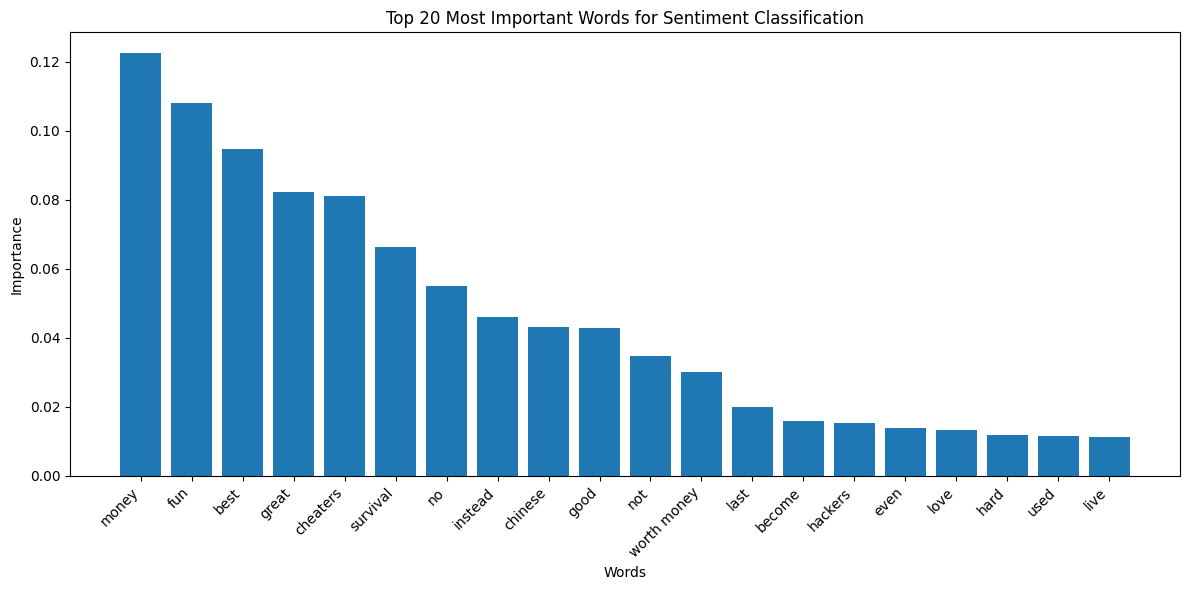

In [25]:
# 6. Feature Importance Visualization
feature_names = list(tfidf.get_feature_names_out())
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

top_20_features = feature_importance['feature'].head(20).tolist()
top_20_importance = feature_importance['importance'].head(20).tolist()

plt.figure(figsize=(12, 6))
indices = np.arange(len(top_20_features))
plt.bar(indices, top_20_importance)
plt.xticks(indices, top_20_features, rotation=45, ha='right')
plt.title('Top 20 Most Important Words for Sentiment Classification')
plt.xlabel('Words')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

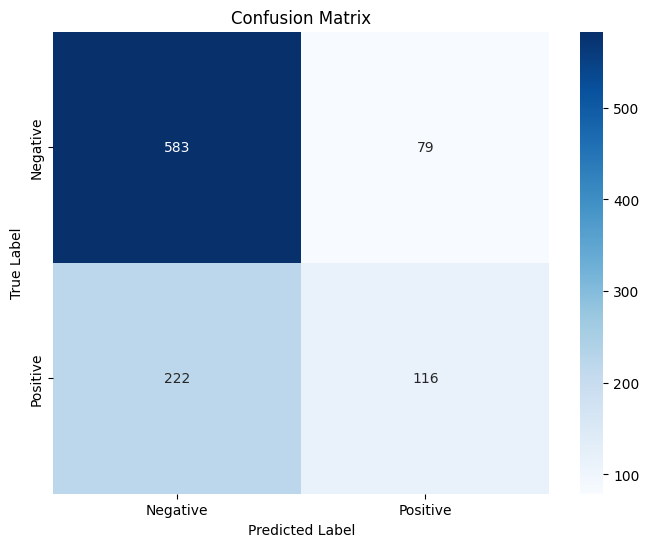

In [26]:
# Create a confusion matrix visualization
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

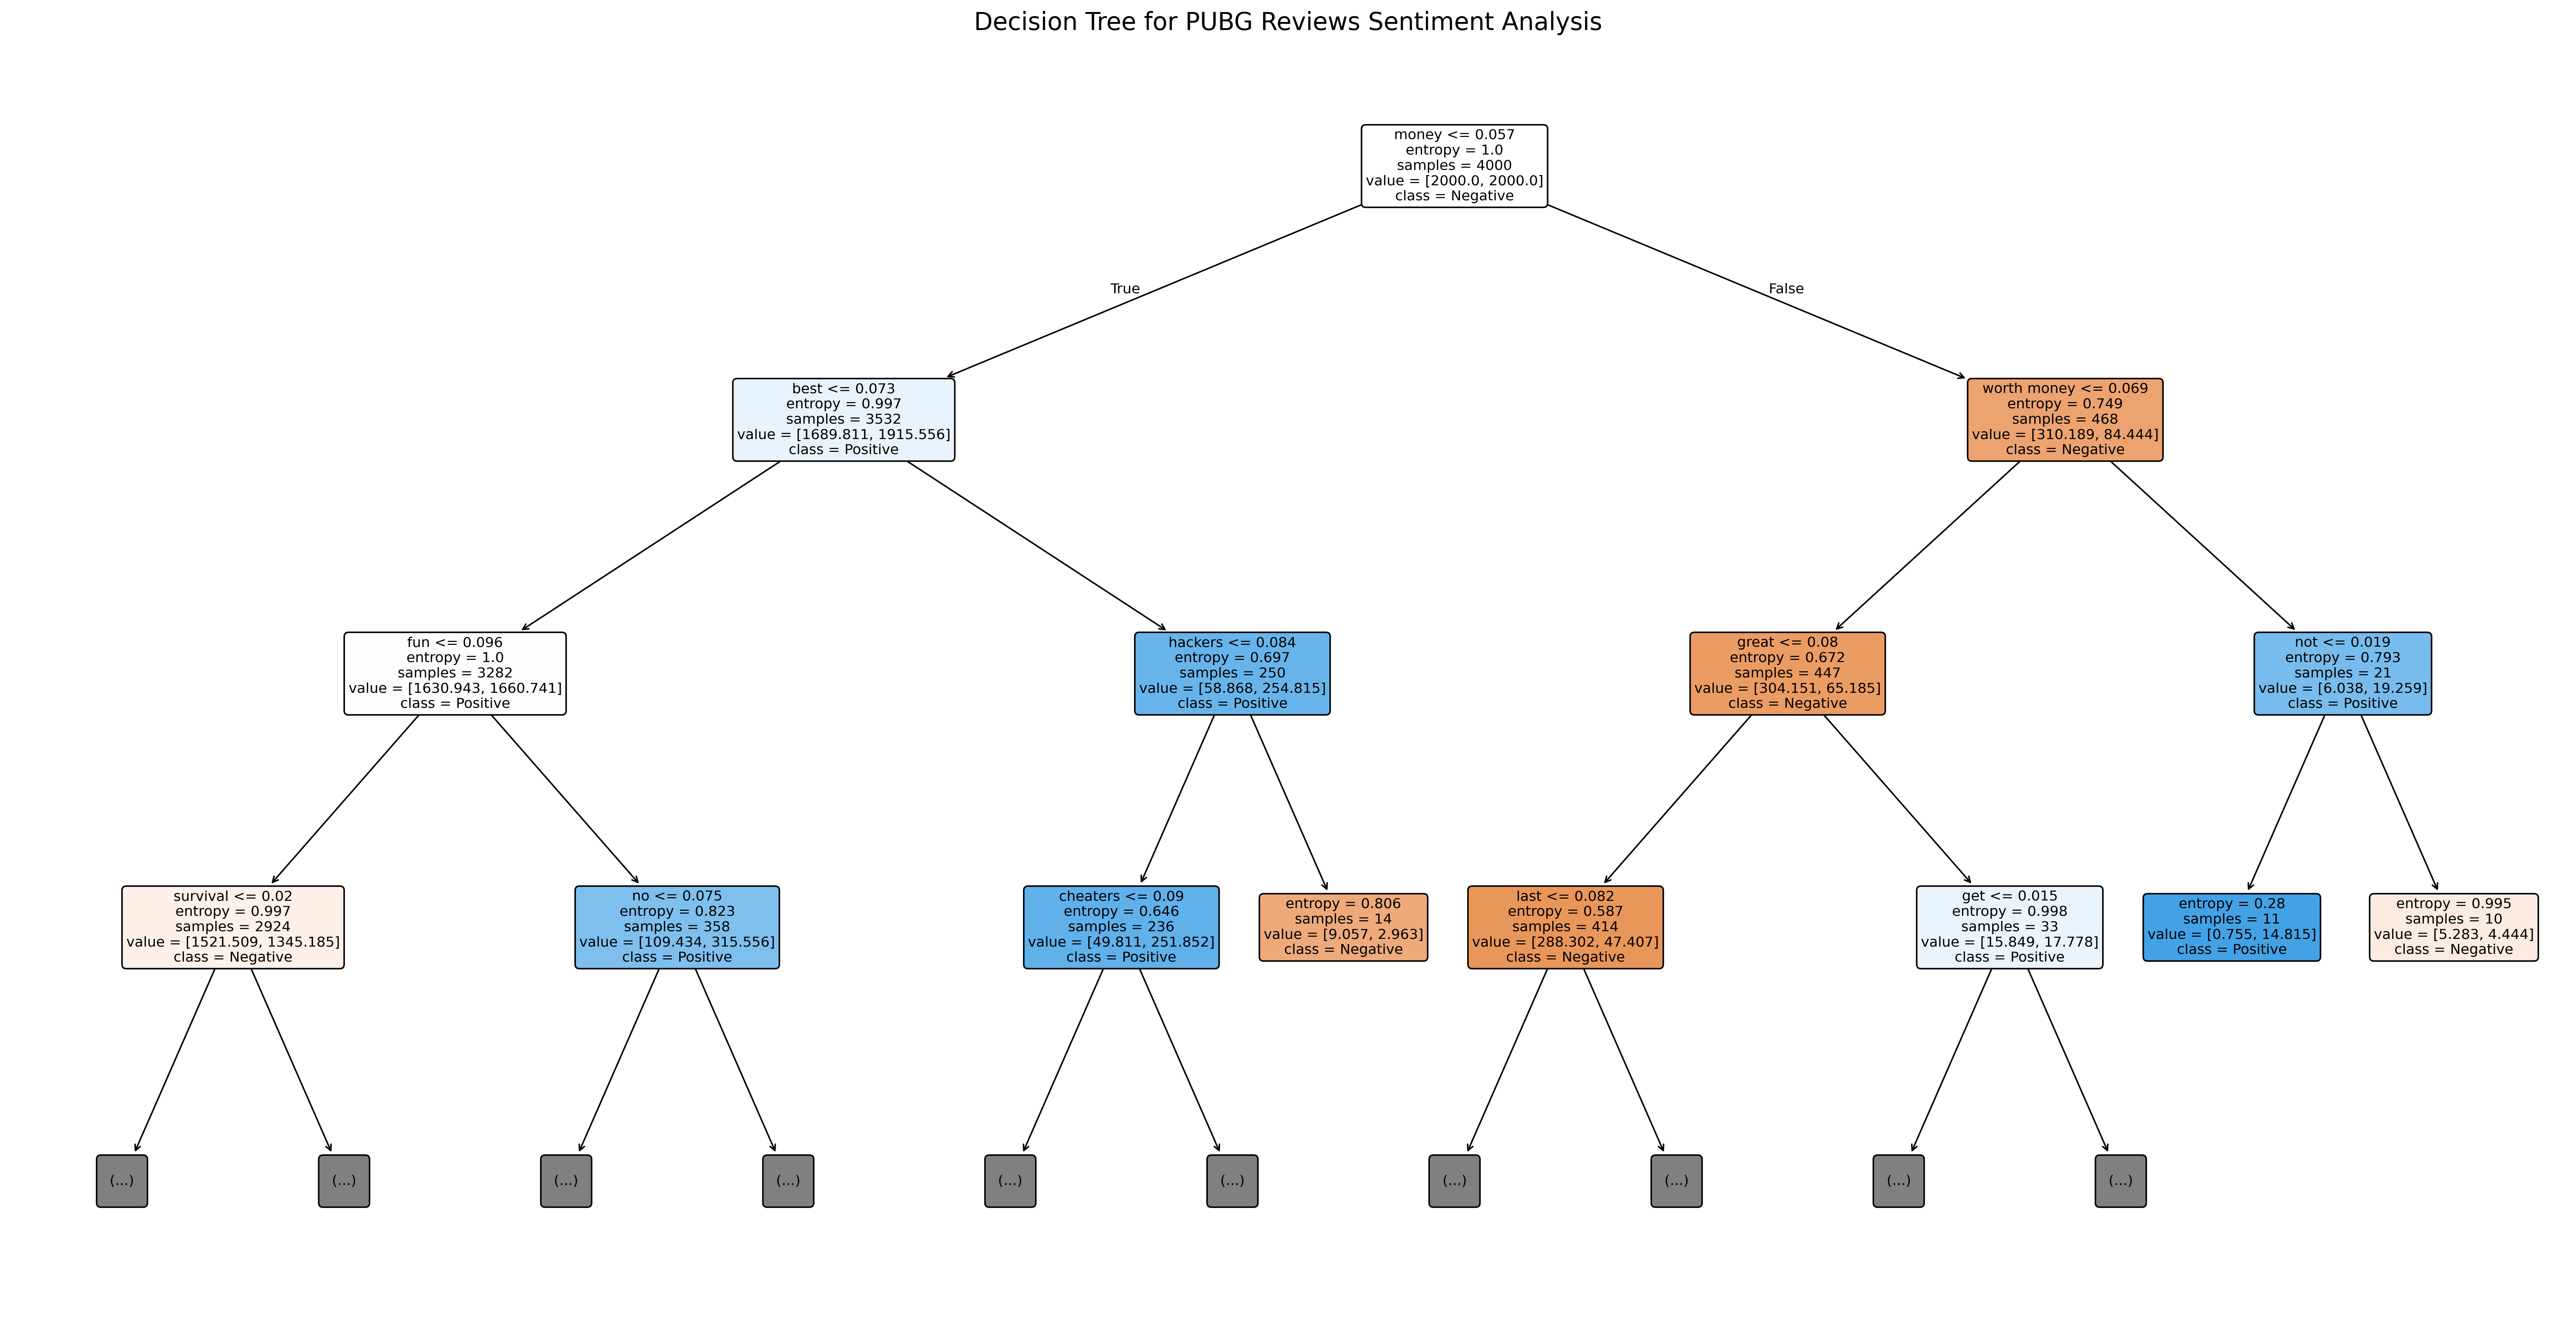

In [ ]:
# 7. Visualize the Decision Tree
plt.figure(figsize=(30,15), dpi=300)
plot_tree(dt_model,
          feature_names=tfidf.get_feature_names_out(),
          class_names=['Negative', 'Positive'],
          filled=True,
          rounded=True,
          max_depth=3)
plt.title('Decision Tree for PUBG Reviews Sentiment Analysis', fontsize=16)
plt.show()


Sentiment Analysis Results:
--------------------------------------------------------------------------------
Review: Lots of fun, but the matchmaking is terrible.
Sentiment: Positive
Confidence: Negative=20.30%, Positive=79.70%
--------------------------------------------------------------------------------
Review: It's okay, not the best but not the worst either.
Sentiment: Positive
Confidence: Negative=20.30%, Positive=79.70%
--------------------------------------------------------------------------------
Review: I had a lot of fun, but there are some issues that need fixing.
Sentiment: Positive
Confidence: Negative=20.30%, Positive=79.70%
--------------------------------------------------------------------------------
Review: While the game has potential, it suffers from numerous bugs.
Sentiment: Negative
Confidence: Negative=51.10%, Positive=48.90%
--------------------------------------------------------------------------------
Review: Best battle royale game ever, highly recommen

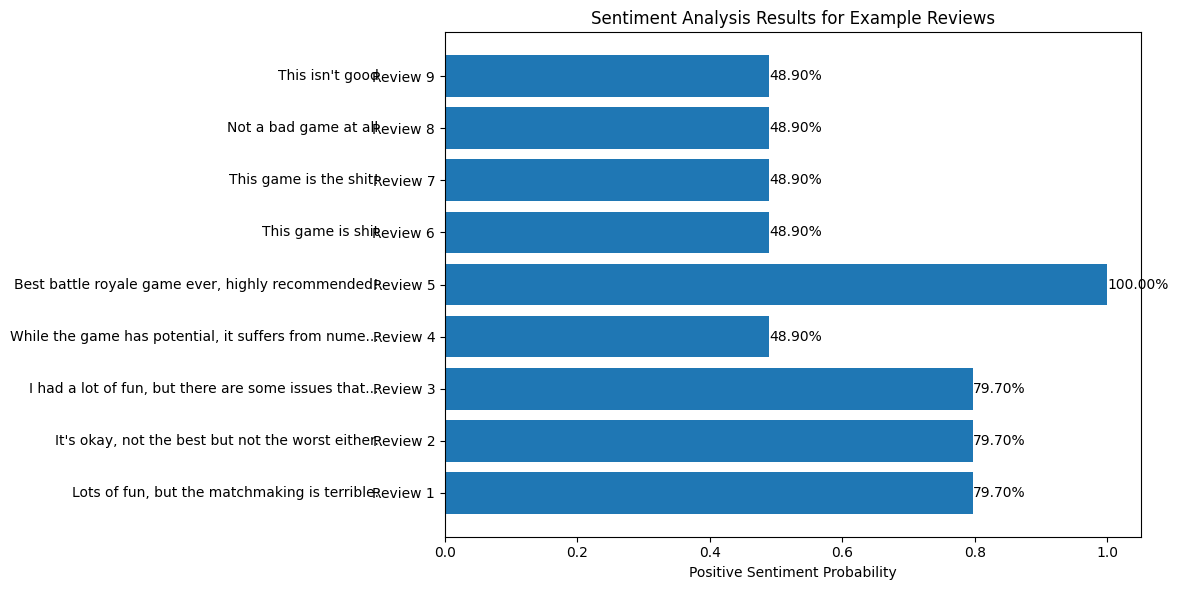

In [28]:
# 8. Utility: Analyze Sentiment for New Text
def analyze_sentiment(text: str, model, vectorizer) -> tuple[str, tuple[float, float]]:
    """Analyze the sentiment of a given text using the trained model.

    Returns:
        tuple: (sentiment label, (negative probability, positive probability))
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])

    # Get probabilities
    probs = model.predict_proba(text_vectorized)[0]
    prediction = model.predict(text_vectorized)[0]

    return ('Positive' if prediction else 'Negative', probs)

# Test the analyzer with some example reviews
example_reviews = [
    "Lots of fun, but the matchmaking is terrible.",
    "It's okay, not the best but not the worst either.",
    "I had a lot of fun, but there are some issues that need fixing.",
    "While the game has potential, it suffers from numerous bugs.",
    "Best battle royale game ever, highly recommended!",
    "This game is shit",
    "This game is the shit!",
    "Not a bad game at all",
    "This isn't good",
]

# Analyze example reviews with improved formatting
print("\nSentiment Analysis Results:")
print("-" * 80)
for review in example_reviews:
    sentiment, probs = analyze_sentiment(review, dt_model, tfidf)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")
    print("-" * 80)

# Visualize the sentiment probabilities for example reviews
fig, ax = plt.subplots(figsize=(12, 6))

# Get probabilities for each review
probs = [analyze_sentiment(review, dt_model, tfidf)[1][1] for review in example_reviews]

# Create bar chart
bars = ax.barh(range(len(example_reviews)), probs)
ax.set_yticks(range(len(example_reviews)))
ax.set_yticklabels([f"Review {i+1}" for i in range(len(example_reviews))])
ax.set_xlabel('Positive Sentiment Probability')
ax.set_title('Sentiment Analysis Results for Example Reviews')

# Add probability values on bars
for i, v in enumerate(probs):
    ax.text(v, i, f'{v:.2%}', va='center')

# Add review text as annotations
for i, review in enumerate(example_reviews):
    ax.text(-0.1, i, review[:50] + '...' if len(review) > 50 else review,
            ha='right', va='center')

plt.tight_layout()
plt.show()

## Model Comparison

Key differences between Decision Trees and other models (Naive Bayes, SVM) for sentiment analysis:

1. **Interpretability**: Decision Trees are much more interpretable than other models, with clear visualization of decision paths
2. **Feature Importance**: Decision Trees provide direct feature importance rankings without additional computation
3. **Non-linear Patterns**: Trees can capture non-linear patterns in the data naturally
4. **No Distribution Assumptions**: Unlike Naive Bayes, trees don't assume feature independence
5. **Performance**: While effective, single trees may not match ensemble methods or SVMs on complex tasks

The choice between models often depends on:
- Need for model interpretability
- Feature relationship complexity
- Dataset size and characteristics
- Available computational resources

## Conclusion

- The Decision Tree model provides an interpretable way to classify PUBG Steam reviews as positive or negative.
- The model achieves good accuracy and offers clear insights into feature importance.
- The tree visualization helps understand how the model makes decisions.

Further improvements could include:
- Using ensemble methods like Random Forests
- Fine-tuning tree parameters
- Exploring more advanced text preprocessing techniques
- Combining with other models in an ensemble